[Load] 1500 points from xy_data.csv


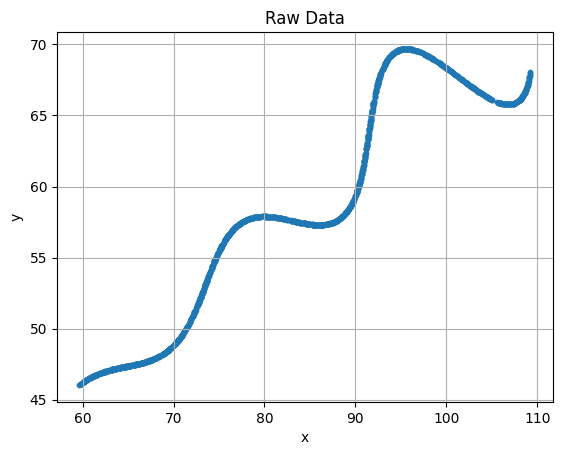

[Pre] Mahalanobis removed 0 points.
[Pre] Residual trimming removed 158 points.


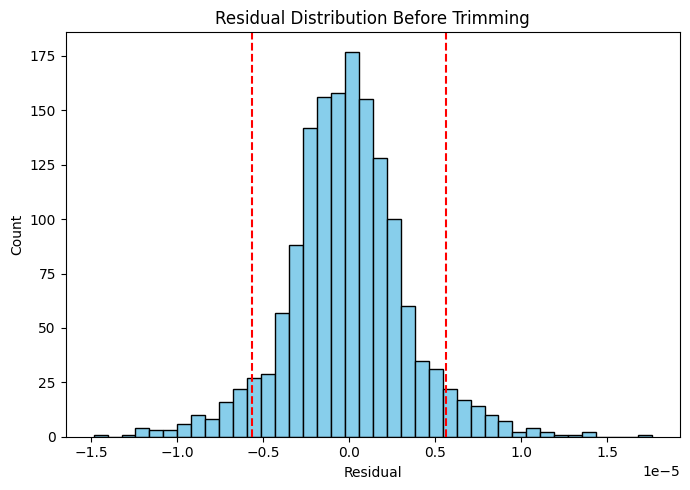

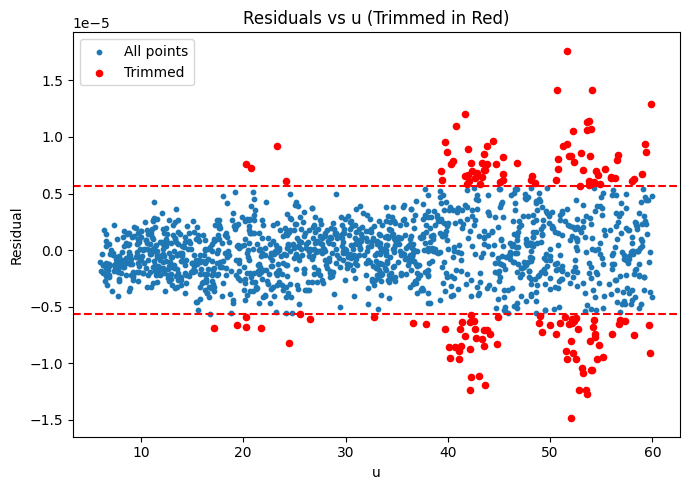

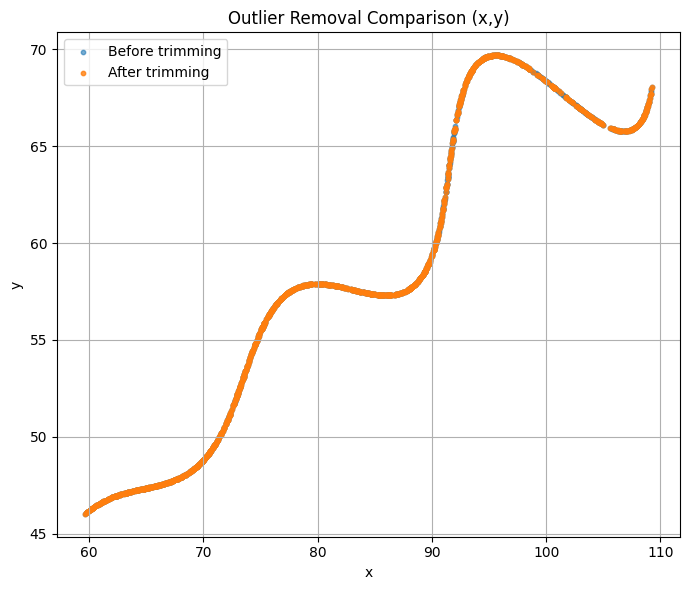

[Diag] Mean=-1.349e-07, Median=-1.860e-07, MAD=1.884e-06

=== Final Parameters ===
θ=29.999973°, M=0.030000, X=54.999998, MAE=1.92e-06


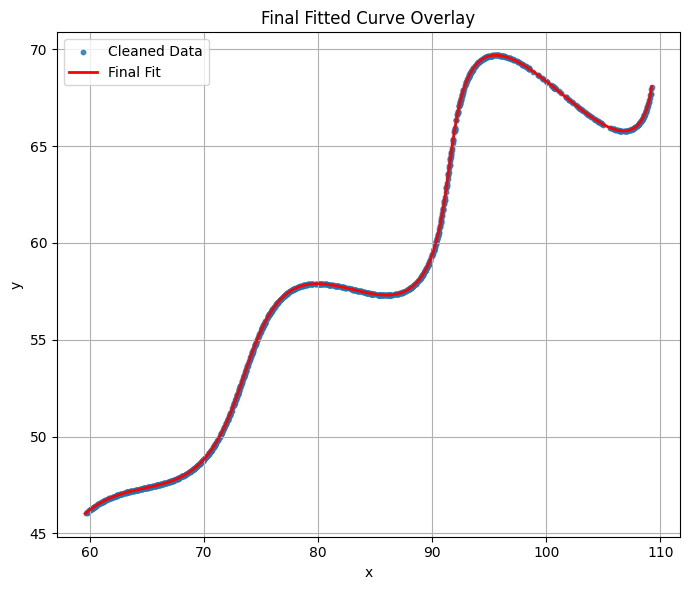

In [7]:
# =========================================
# Best Preprocessing + Best Model (Integrated)
# PCA → Envelope → 1D Phase Align → Robust LM (Huber IRLS)
# Mahalanobis + Residual Trimming + Diagnostics
# =========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv

# -------------- CONFIG --------------
CSV_PATH = "xy_data.csv"   # dataset path

Y0         = 42.0
THETA_MIN  = np.deg2rad(0.1)
THETA_MAX  = np.deg2rad(49.9)
X_MIN, X_MAX = 0.0, 100.0
M_MIN, M_MAX = -0.05, 0.05
MAHA_CHI2  = 13.816
RESID_K    = 3.0
HUBER_DELTA = 1.0

# -------------- UTILITIES --------------
def load_xy(path):
    df = pd.read_csv(path)
    cols = [c.lower() for c in df.columns]
    if "x" in cols and "y" in cols:
        x = df[df.columns[cols.index("x")]].to_numpy(float)
        y = df[df.columns[cols.index("y")]].to_numpy(float)
    else:
        num = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
        x = df[num[0]].to_numpy(float)
        y = df[num[1]].to_numpy(float)
    mask = np.isfinite(x) & np.isfinite(y)
    return x[mask], y[mask]

def mahalanobis_mask(x, y0, chi2):
    Z = np.stack([x - np.mean(x), y0 - np.mean(y0)], 1)
    C = np.cov(Z, rowvar=False) + 1e-9 * np.eye(2)
    invC = inv(C)
    d2 = np.einsum('ij,jk,ik->i', Z, invC, Z)
    return d2 <= chi2, d2

def pca_theta(x, y0):
    XY = np.stack([x, y0], 1)
    Xc = XY - XY.mean(0)
    C = Xc.T @ Xc / len(XY)
    w, V = np.linalg.eigh(C)
    v = V[:, np.argmax(w)]
    th = np.arctan2(v[1], v[0])
    if th < 0: th += np.pi
    if th > THETA_MAX: th = np.pi - th
    return th

def rotate_uv(x, y0, th, X):
    c, s = np.cos(th), np.sin(th)
    x0 = x - X
    u = x0*c + y0*s
    v = -x0*s + y0*c
    return u, v

def envelope_M(u, v):
    a = np.abs(v)
    o = np.argsort(u)
    us, as_ = u[o], a[o]
    peaks_u, peaks_a, last = [], [], -1e9
    for i in range(1, len(us)-1):
        if as_[i] > as_[i-1] and as_[i] > as_[i+1] and us[i]-last >= 8:
            peaks_u.append(us[i]); peaks_a.append(as_[i]); last = us[i]
    if len(peaks_u) >= 2 and np.all(np.array(peaks_a) > 0):
        M = np.polyfit(peaks_u, np.log(peaks_a), 1)[0]
    else: M = 0.0
    return float(np.clip(M, M_MIN, M_MAX))

def phase_align_X(x, y0, th, M, X0):
    c, s = np.cos(th), np.sin(th)
    def mae(Xv):
        u, v = rotate_uv(x, y0, th, Xv)
        return np.mean(np.abs(v - np.exp(M*u)*np.sin(0.3*u)))
    grid = np.clip(np.linspace(X0-5, X0+5, 201), X_MIN, X_MAX)
    errs = [mae(xx) for xx in grid]
    return float(grid[np.argmin(errs)])

def residuals_jac(x, y0, th, X, M):
    c, s = np.cos(th), np.sin(th)
    x0 = x - X
    u = x0*c + y0*s
    v = -x0*s + y0*c
    g  = np.exp(M*u) * np.sin(0.3*u)
    r  = v - g
    gu = np.exp(M*u) * (M*np.sin(0.3*u) + 0.3*np.cos(0.3*u))
    J = np.stack([-u - gu*v, s + c*gu, -u*g], 1)
    return r, J, u, v, g

def huber_w(r, delta):
    if delta is None:
        return np.ones_like(r)
    a = np.abs(r)
    w = np.ones_like(r)
    mask = a > delta
    w[mask] = delta / (a[mask] + 1e-12)
    return w

def mad(a):
    return np.median(np.abs(a - np.median(a))) + 1e-12

def lm_robust(x, y0, th, X, M, iters=60, lam0=1e-2, huber_delta=None):
    lam = lam0
    p = np.array([th, X, M], float)
    for _ in range(iters):
        r, J, u, v, g = residuals_jac(x, y0, p[0], p[1], p[2])
        w = huber_w(r, huber_delta)
        JW = J * w[:, None]
        H = JW.T @ J + lam * np.eye(3)
        gvec = JW.T @ r
        try:
            d = -np.linalg.solve(H, gvec)
        except np.linalg.LinAlgError:
            break
        q = p + d
        q[0] = np.clip(q[0], THETA_MIN, THETA_MAX)
        q[1] = np.clip(q[1], X_MIN, X_MAX)
        q[2] = np.clip(q[2], M_MIN, M_MAX)
        r2, _, _, _, _ = residuals_jac(x, y0, q[0], q[1], q[2])
        if 0.5*np.dot(r2, r2) < 0.5*np.dot(r, r):
            p = q
            lam *= 0.3
        else:
            lam *= 3.0
        if np.linalg.norm(d) < 1e-12:
            break
    return p

# -------------- MAIN PIPELINE --------------
x_raw, y_raw = load_xy(CSV_PATH)
print(f"[Load] {len(x_raw)} points from {CSV_PATH}")

plt.figure()
plt.scatter(x_raw, y_raw, s=10, alpha=0.9)
plt.title("Raw Data"); plt.xlabel("x"); plt.ylabel("y"); plt.grid(True); plt.show()

y0_raw = y_raw - Y0

maskM, d2 = mahalanobis_mask(x_raw, y0_raw, MAHA_CHI2)
x1, y1 = x_raw[maskM], y_raw[maskM]
print(f"[Pre] Mahalanobis removed {(~maskM).sum()} points.")

th0 = pca_theta(x1, y1 - Y0)
c0, s0 = np.cos(th0), np.sin(th0)
u_raw = x1*c0 + (y1 - Y0)*s0
X0 = np.clip((u_raw.mean() - 33) / c0, X_MIN, X_MAX)
u0, v0 = rotate_uv(x1, y1 - Y0, th0, X0)
M0 = envelope_M(u0, v0)
X1 = phase_align_X(x1, y1 - Y0, th0, M0, X0)

th1, X2, M1 = lm_robust(x1, y1 - Y0, th0, X1, M0, iters=40)

r1, _, u1, v1, _ = residuals_jac(x1, y1 - Y0, th1, X2, M1)
mad_r = mad(r1)
trim_mask = np.abs(r1) <= RESID_K * mad_r
x2, y2 = x1[trim_mask], y1[trim_mask]
print(f"[Pre] Residual trimming removed {(~trim_mask).sum()} points.")

plt.figure(figsize=(7,5))
plt.hist(r1, bins=40, color="skyblue", edgecolor="k")
plt.axvline(3*mad_r, color="r", ls="--"); plt.axvline(-3*mad_r, color="r", ls="--")
plt.title("Residual Distribution Before Trimming")
plt.xlabel("Residual"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,5))
plt.scatter(u1, r1, s=10, label="All points")
plt.scatter(u1[~trim_mask], r1[~trim_mask], s=20, c='r', label="Trimmed")
plt.axhline(3*mad_r, color='r', ls='--'); plt.axhline(-3*mad_r, color='r', ls='--')
plt.xlabel("u"); plt.ylabel("Residual"); plt.legend()
plt.title("Residuals vs u (Trimmed in Red)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,6))
plt.scatter(x1, y1, s=10, alpha=0.6, label="Before trimming")
plt.scatter(x2, y2, s=10, alpha=0.8, label="After trimming")
plt.title("Outlier Removal Comparison (x,y)")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

print(f"[Diag] Mean={r1.mean():.3e}, Median={np.median(r1):.3e}, MAD={mad_r:.3e}")

# --- Final Refit ---
th_init = pca_theta(x2, y2 - Y0)
c0, s0 = np.cos(th_init), np.sin(th_init)
u_ = x2*c0 + (y2 - Y0)*s0
X_init = np.clip((u_.mean() - 33)/c0, X_MIN, X_MAX)
u_i, v_i = rotate_uv(x2, y2 - Y0, th_init, X_init)
M_init = envelope_M(u_i, v_i)
X_init = phase_align_X(x2, y2 - Y0, th_init, M_init, X_init)
th, X, M = lm_robust(x2, y2 - Y0, th_init, X_init, M_init, huber_delta=HUBER_DELTA)

# --- Final Diagnostics ---
u, v = rotate_uv(x2, y2 - Y0, th, X)
v_pred = np.exp(M*u) * np.sin(0.3*u)
mae = np.mean(np.abs(v - v_pred))
print(f"\n=== Final Parameters ===\nθ={np.degrees(th):.6f}°, M={M:.6f}, X={X:.6f}, MAE={mae:.2e}")

t = np.linspace(6, 60, 1000)
c, s = np.cos(th), np.sin(th)
x_fit = t*c - np.exp(M*t)*np.sin(0.3*t)*s + X
y_fit = Y0 + t*s + np.exp(M*t)*np.sin(0.3*t)*c

plt.figure(figsize=(7,6))
plt.scatter(x2, y2, s=10, alpha=0.8, label="Cleaned Data")
plt.plot(x_fit, y_fit, 'r', lw=2, label="Final Fit")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.grid(True)
plt.title("Final Fitted Curve Overlay")
plt.tight_layout(); plt.show()
